<a href="https://colab.research.google.com/github/peisuke/generative_ai_notebooks/blob/main/25_AnimateDiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://note.com/npaka/n/n3af415daa362

In [2]:
# パッケージのインストール
!git clone https://github.com/guoyww/AnimateDiff
!pip install -q torch==2.0.1+cu118 torchvision==0.15.2+cu118 torchaudio==2.0.2+cu118 torchtext==0.15.2 torchdata==0.6.1 --extra-index-url https://download.pytorch.org/whl/cu118 -U
!pip install einops omegaconf safetensors diffusers[torch]==0.11.1 transformers xformers==0.0.20 triton==2.0.0
!rm -rf /content/AnimateDiff/models/StableDiffusion
!git clone -b fp16 https://huggingface.co/runwayml/stable-diffusion-v1-5 /content/AnimateDiff/models/StableDiffusion/
%cd AnimateDiff

Cloning into 'AnimateDiff'...
remote: Enumerating objects: 526, done.
remote: Counting objects: 100% (275/275), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 526 (delta 189), reused 127 (delta 125), pack-reused 251
Receiving objects: 100% (526/526), 54.18 MiB | 13.83 MiB/s, done.
Resolving deltas: 100% (208/208), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 945.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 95.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 89.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 101.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Inst

Cloning into '/content/AnimateDiff/models/StableDiffusion'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 194 (delta 34), reused 7 (delta 7), pack-reused 142
Receiving objects: 100% (194/194), 541.34 KiB | 25.78 MiB/s, done.
Resolving deltas: 100% (61/61), done.
Filtering content: 100% (4/4), 2.55 GiB | 138.08 MiB/s, done.
/content/AnimateDiff


In [3]:
# モーションモジュールのダウンロード
!wget -P /content/AnimateDiff/models/Motion_Module https://huggingface.co/camenduru/AnimateDiff/resolve/main/mm_sd_v15_v2.ckpt

# モデルのダウンロード
!wget -P /content/AnimateDiff/models/DreamBooth_LoRA https://huggingface.co/gsdf/Counterfeit-V3.0/resolve/main/Counterfeit-V3.0_fix_fp16.safetensors

--2023-12-14 06:31:13--  https://huggingface.co/camenduru/AnimateDiff/resolve/main/mm_sd_v15_v2.ckpt
Resolving huggingface.co (huggingface.co)... 13.33.33.102, 13.33.33.55, 13.33.33.20, ...
Connecting to huggingface.co (huggingface.co)|13.33.33.102|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/91/f8/91f8ac1397bf6d5084e00d57bf70d8e7e4fe6518c6ac2b58a0c211cce4d77335/69ed0f5fef82b110aca51bcab73b21104242bc65d6ab4b8b2a2a94d31cad1bf0?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27mm_sd_v15_v2.ckpt%3B+filename%3D%22mm_sd_v15_v2.ckpt%22%3B&Expires=1702791597&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwMjc5MTU5N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy85MS9mOC85MWY4YWMxMzk3YmY2ZDUwODRlMDBkNTdiZjcwZDhlN2U0ZmU2NTE4YzZhYzJiNThhMGMyMTFjY2U0ZDc3MzM1LzY5ZWQwZjVmZWY4MmIxMTBhY2E1MWJjYWI3M2IyMTEwNDI0MmJjNjVkNmFiNGI4YjJhMmE5NGQzMWNhZDFiZjA%7Ecm

In [4]:
setting = """RealisticVision:
  inference_config: "configs/inference/inference-v2.yaml"
  motion_module:
    - "models/Motion_Module/mm_sd_v15_v2.ckpt"

  dreambooth_path: "models/DreamBooth_LoRA/Counterfeit-V3.0_fix_fp16.safetensors"
  lora_model_path: ""

  seed:           [1]
  steps:          25
  guidance_scale: 7.5

  prompt:
    - "cute cat ear maid, best quality, high quality"

  n_prompt:
    - "worst quality, low quality, monochrome"
"""
with open("0-Counterfeit-V3.0.yaml", "w") as f:
    f.write(setting)

In [10]:
!sed -i 's/text_model.load_state_dict(text_model_dict)/text_model.load_state_dict(text_model_dict, strict=False)/' \
    animatediff/utils/convert_from_ckpt.py

In [11]:
import inspect
import os
from omegaconf import OmegaConf

import torch

import diffusers
from diffusers import AutoencoderKL, DDIMScheduler

from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer

from animatediff.models.unet import UNet3DConditionModel
from animatediff.pipelines.pipeline_animation import AnimationPipeline
from animatediff.utils.util import save_videos_grid
from animatediff.utils.util import load_weights
from diffusers.utils.import_utils import is_xformers_available

In [13]:
*_, func_args = inspect.getargvalues(inspect.currentframe())
func_args = dict(func_args)

os.makedirs("output")

config  = OmegaConf.load("0-Counterfeit-V3.0.yaml")
samples = []

In [20]:
sample_idx = 0
config_key = "RealisticVision"
model_config = config[config_key]

motion_modules = model_config.motion_module
motion_modules = [motion_modules] if isinstance(motion_modules, str) else list(motion_modules)

inference_config = "configs/inference/inference-v1.yaml"
pretrained_model_path = "/content/AnimateDiff/models/StableDiffusion"
W = 512
H = 512
L = 16

for motion_module in motion_modules:
    inference_config = OmegaConf.load(model_config.get("inference_config", inference_config))

    ### >>> create validation pipeline >>> ###
    tokenizer    = CLIPTokenizer.from_pretrained(pretrained_model_path, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(pretrained_model_path, subfolder="text_encoder")
    vae          = AutoencoderKL.from_pretrained(pretrained_model_path, subfolder="vae")
    unet         = UNet3DConditionModel.from_pretrained_2d(pretrained_model_path, subfolder="unet", unet_additional_kwargs=OmegaConf.to_container(inference_config.unet_additional_kwargs))

    if is_xformers_available(): unet.enable_xformers_memory_efficient_attention()
    else: assert False

    pipeline = AnimationPipeline(
        vae=vae, text_encoder=text_encoder, tokenizer=tokenizer, unet=unet,
        scheduler=DDIMScheduler(**OmegaConf.to_container(inference_config.noise_scheduler_kwargs)),
    ).to("cuda")

    pipeline = load_weights(
        pipeline,
        # motion module
        motion_module_path         = motion_module,
        motion_module_lora_configs = model_config.get("motion_module_lora_configs", []),
        # image layers
        dreambooth_model_path      = model_config.get("dreambooth_path", ""),
        lora_model_path            = model_config.get("lora_model_path", ""),
        lora_alpha                 = model_config.get("lora_alpha", 0.8),
    ).to("cuda")

    prompts      = model_config.prompt
    n_prompts    = list(model_config.n_prompt) * len(prompts) if len(model_config.n_prompt) == 1 else model_config.n_prompt

    random_seeds = model_config.get("seed", [-1])
    random_seeds = [random_seeds] if isinstance(random_seeds, int) else list(random_seeds)
    random_seeds = random_seeds * len(prompts) if len(random_seeds) == 1 else random_seeds

    config[config_key].random_seed = []
    for prompt_idx, (prompt, n_prompt, random_seed) in enumerate(zip(prompts, n_prompts, random_seeds)):

        # manually set random seed for reproduction
        if random_seed != -1: torch.manual_seed(random_seed)
        else: torch.seed()
        config[config_key].random_seed.append(torch.initial_seed())

        print(f"current seed: {torch.initial_seed()}")
        print(f"sampling {prompt} ...")
        sample = pipeline(
            prompt,
            negative_prompt     = n_prompt,
            num_inference_steps = model_config.steps,
            guidance_scale      = model_config.guidance_scale,
            width               = W,
            height              = H,
            video_length        = L,
        ).videos
        samples.append(sample)

        #prompt = "-".join((prompt.replace("/", "").split(" ")[:10]))
        #save_videos_grid(sample, f"{savedir}/sample/{sample_idx}-{prompt}.gif")
        #print(f"save to {savedir}/sample/{prompt}.gif")

        #sample_idx += 1

samples = torch.concat(samples)
save_videos_grid(samples, f"output/sample.gif", n_rows=4)

loaded temporal unet's pretrained weights from /content/AnimateDiff/models/StableDiffusion/unet ...
### missing keys: 588; 
### unexpected keys: 0;
### Temporal Module Parameters: 453.20928 M
load motion module from models/Motion_Module/mm_sd_v15_v2.ckpt
load dreambooth model from models/DreamBooth_LoRA/Counterfeit-V3.0_fix_fp16.safetensors


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

current seed: 1
sampling cute cat ear maid, best quality, high quality ...


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:05<00:00,  2.67it/s]


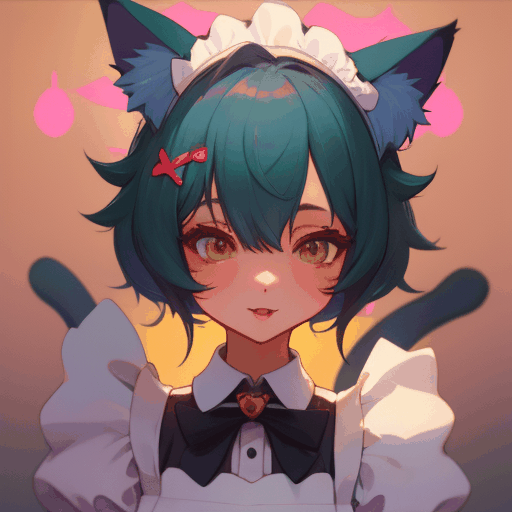

In [30]:
from PIL import Image
Image.open("/content/AnimateDiff/output/sample.gif")